In [1]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.

import os
from dotenv import load_dotenv
load_dotenv()
module_path = os.getenv("MODULE_SCENARIO_PATH", default="/app")


import sys
sys.path.insert(0, module_path)

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score


from torch_geometric.nn import TGNMemory
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

from dataclasses import asdict
import scenario_identification.utils.path_helper as path_helper
from scenario_identification.utils.path_helper import DatasetTask, DatasetType, set_constants
import scenario_identification.utils.data_loader as loader

import scenario_identification.visualization.evaluation as presenter 
from scenario_identification.models.classifier.MLP import MLP
from scenario_identification.utils.argument_setup import Args
from scenario_identification.utils.path_helper import get_node_embedding_output_folder_path
from scenario_identification.utils.early_stopper import EarlyStopper
from scenario_identification.utils.path_helper import DatasetType, get_model_output_path


from scenario_identification.models.link_predictor.LinearLinkPredictor import LinkPredictor
from scenario_identification.models.tgn.GraphAttentionEmbedding import GraphAttentionEmbedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import pandas as pd

args=Args()

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim
INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES = args.include_artificial_negative_samples



negative_samples_str = "Negative_Samples" if args.include_artificial_negative_samples else "NoNegative_Samples"
experiment_name = f"{args.embedding_module}_Attn_{args.data}_{negative_samples_str}"
report_name = f"evaluation_report_{experiment_name}.txt"



DATASET_TYPE = DatasetType.NODE_CLASSIFICATION_DISTANCE_LABELS.value
DATASET_TASK = DatasetTask.NODE_CLASSIFICATION.value

set_constants(DATASET_TYPE, DATASET_TASK, experiment_name)


In [2]:
dataset_path = path_helper.get_dataset_file_path()
dataset_path = "/app/scenario_identification/data/iot-unsw/iot-unsw_edge_prediction.csv"
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(columns=['Unnamed: 0'])
if not INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES:
    dataset = dataset[dataset['relationship_label'] != -1]



In [3]:
    # node_features_columns = ['dist', 'latitude', 'longitude', 'shape_status_DEFORMED', 
node_features = ['shape_status_DEFORMED', 
                'shape_status_ORIGINAL_MANUFACTURED',  
                'signal', 'speed', 'status_ACTIVE', 'status_ERROR', 
                'status_INACTIVE', 'type_EMERGENCY_CENTER', 
                'type_INDUCTION_LOOP', 'type_SMART_PHONE', 'type_TRAFFIC_CAMERA', 
                'type_TRAFFIC_LIGHT', 'type_VEHICLE']

edge_features = ['dist']

label = 'label'

# dataset = dataset[dataset['relationship_label'] != -1]

# EXPERIMENT_NAME = f"TGN-GraphAttention_bs-Samples_{'only positive' if INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES else 'both'}"




dataset

,u,i,ts,dist,relationship_label,label,latitude,longitude,shape_status_DEFORMED,shape_status_ORIGINAL_MANUFACTURED,...,speed,status_ACTIVE,status_ERROR,status_INACTIVE,type_EMERGENCY_CENTER,type_INDUCTION_LOOP,type_SMART_PHONE,type_TRAFFIC_CAMERA,type_TRAFFIC_LIGHT,type_VEHICLE
0,6.0,7.0,1.0,23.29,1.0,0.0,345.64,871.20,0.0,1.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,6.0,7.0,2.0,27.57,1.0,0.0,349.21,873.76,0.0,1.0,...,4.365469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,12.0,8.0,3.0,16.41,1.0,0.0,329.85,167.47,0.0,1.0,...,10.705728,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,6.0,7.0,4.0,46.17,1.0,0.0,364.43,884.89,0.0,1.0,...,9.039484,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15,12.0,8.0,4.0,17.67,1.0,0.0,334.10,176.66,0.0,1.0,...,10.135585,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111808,308.0,203.0,1333.0,41.03,1.0,0.0,407.69,258.27,0.0,1.0,...,1.119928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111809,308.0,260.0,1333.0,42.11,1.0,0.0,409.53,285.10,0.0,1.0,...,1.112197,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111810,295.0,300.0,1333.0,11.23,1.0,0.0,717.72,300.44,0.0,1.0,...,2.342355,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111814,275.0,296.0,1333.0,32.97,1.0,0.0,376.17,265.94,0.0,1.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
import pandas as pd
import random

def downsample_dataframe(df):
    unique_timesteps = df['ts'].unique()
    final_df = pd.DataFrame()

    for ts in unique_timesteps:
        df_ts = df[df['ts'] == ts]
        
        if len(df_ts['label'].unique()) < 2:
            continue

        min_class_count = min(df_ts['label'].value_counts())

        temp_df = pd.DataFrame()
        for label in df_ts['label'].unique():
            sample_df = df_ts[df_ts['label'] == label].sample(n=min_class_count, random_state=1)
            temp_df = pd.concat([temp_df, sample_df])

        final_df = pd.concat([final_df, temp_df])
        
    return final_df

# Assume dataset is your original DataFrame
downsampled_dataset = downsample_dataframe(dataset)


In [5]:
downsampled_dataset

,u,i,ts,dist,relationship_label,label,latitude,longitude,shape_status_DEFORMED,shape_status_ORIGINAL_MANUFACTURED,...,speed,status_ACTIVE,status_ERROR,status_INACTIVE,type_EMERGENCY_CENTER,type_INDUCTION_LOOP,type_SMART_PHONE,type_TRAFFIC_CAMERA,type_TRAFFIC_LIGHT,type_VEHICLE
3323,46.0,14.0,152.0,18.52,1.0,0.0,823.78,661.94,0.0,1.0,...,5.731119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3348,23.0,39.0,152.0,45.87,1.0,1.0,402.11,288.55,0.0,1.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3363,14.0,46.0,153.0,22.07,1.0,0.0,839.90,655.27,0.0,1.0,...,1.215498,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3382,23.0,39.0,153.0,45.87,1.0,1.0,402.11,288.55,0.0,1.0,...,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3404,38.0,19.0,154.0,16.73,1.0,0.0,857.28,442.30,0.0,1.0,...,1.397309,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111407,288.0,144.0,1330.0,12.90,1.0,1.0,705.70,872.99,1.0,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
111574,289.0,252.0,1331.0,7.94,1.0,0.0,457.57,739.11,0.0,1.0,...,1.715561,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111515,290.0,237.0,1331.0,23.99,1.0,1.0,847.79,651.73,1.0,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
111809,308.0,260.0,1333.0,42.11,1.0,0.0,409.53,285.10,0.0,1.0,...,1.112197,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
dataset = downsampled_dataset

In [7]:

# dataset = loader.remove_self_loops(dataset)

data, slices = loader.process_node_classification_dataset(dataset, node_features=node_features, edge_features=edge_features, label=label)

num_node_features = data.destination_node_features.shape[1]
num_edge_features = data.msg.shape[1]
num_features = num_node_features + num_edge_features



Counter({0.0: 298, 1.0: 298})


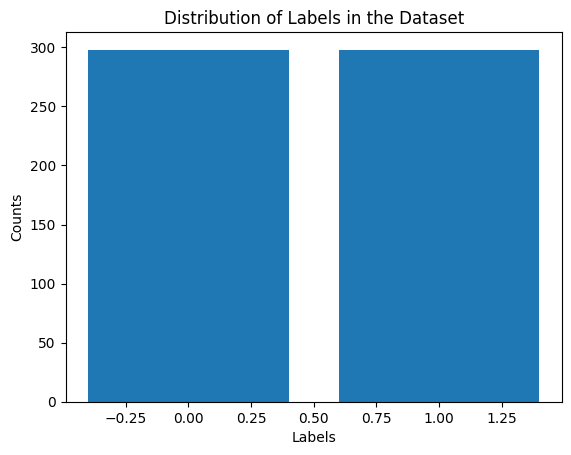

In [8]:
train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.10, test_ratio=0.20)
presenter.plot_label_distribution(train_data)




In [9]:
train_loader, val_loader, test_loader = loader.get_temporal_classification_data_loader(train_data, val_data, test_data, args.bs)

In [10]:
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)
memory_dim = time_dim = embedding_dim = num_features

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)


gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)


In [11]:
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

gnn.load_state_dict(torch.load('/app/scenario_identification/output/evaluation/graph_attention_Attn_wikipedia_NoNegativeSamples/model/link_prediction_model.pt'))
gnn.eval()

decoder = MLP(dim=num_features).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)

In [12]:



import numpy as np


def train(f):
    memory.eval()
    gnn.eval()
    decoder.train()

    memory.reset_state()  
    neighbor_loader.reset_state()  

    total_loss = 0
    overall_batches = len(train_loader)
    
    print(f"Length of batches: {overall_batches}")
    
    for k, batch in enumerate(train_loader):
    # for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        
        # Destination?
        hidden_state = z[assoc[batch.src]]

        out = decoder(hidden_state)
        pred = out.sigmoid()
        
        loss = criterion(pred, batch.y)

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        
        total_loss += float(loss) * batch.num_events
        
        if k % 100 == 0:
            print(f"Trainings batch loaded: {k} / {overall_batches}""")
            f.write(f"Trainings batch loaded: {k} / {overall_batches}\n")

    return total_loss / train_data.num_events



@torch.no_grad()
def test(loader,f):
    memory.eval()
    gnn.eval()
    # link_pred.eval()
    decoder.eval()


    total_loss = 0
    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.
    
    overall_batches = len(loader)
    aps, aucs = [], []
    
    ground_truth, predictions = [], []
    
    for k, batch in enumerate(loader):
    
        batch = batch.to(device)
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))

        out = decoder(z[assoc[batch.src]])        
        # out = classifier(z[assoc[batch.src]])
        
        y_pred = out.sigmoid()
        
        y_true = batch.y
        loss = criterion(y_pred, batch.y)
        
        ground_truth.extend(y_true)
        predictions.extend(y_pred)
        
        aps.append(average_precision_score(batch.y, y_pred))
        
        if len(np.unique(batch.y.cpu().numpy())) > 1:
            aucs.append(roc_auc_score(batch.y, y_pred))
        else:
            print("Skipped ROC AUC computation for this batch as it contains only one class.")


        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
        
        total_loss += float(loss) * batch.num_events
        if k % 100 == 0:
            print(f"Test batch loaded: {k} / {overall_batches}""")
            f.write(f"Test batch loaded: {k} / {overall_batches}\n")
        
        
    total_loss = total_loss / train_data.num_events
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), total_loss, ground_truth, predictions 

train_losses = []
validation_losses = []

accuracy_list = []
f1_score_list = []
recall_list = []
precision_list = []

trainings_log_file = path_helper.get_trainings_logs_path()

trainings_logs = None
try: 
    trainings_logs = open(trainings_log_file, "w")
except:
    print("Could not open file")
    exit(1)


for epoch in range(1, args.n_epoch + 1):
    train_loss = train(trainings_logs)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        n_id = torch.arange(memory.num_nodes, device=device)  # assuming memory has num_nodes attribute to get all nodes
        embeddings, _ = memory(n_id)
        output_path_node_embedding = get_node_embedding_output_folder_path()
        presenter.plot_embeddings(embeddings, epoch=5, folder_path=output_path_node_embedding, file_name=f'Node_Embedding_Epoch_{epoch}.png')
    
    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    trainings_logs.write(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}\n')
    
    
    val_ap, val_auc, val_loss, _, _ = test(val_loader,trainings_logs)
    validation_losses.append(val_loss)    
    test_ap, test_auc, test_loss, ground_truth , predictions = test(test_loader,trainings_logs)
    
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')
    trainings_logs.write(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}\n')
    trainings_logs.write(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}\n')
    
    if early_stopper.early_stop(val_loss):         
        print(f"Early stopping: {epoch} epochs")
        trainings_logs.write(f"Early stopping: {epoch} epochs")    
        break
    
    ground_truth = [int(t.item()) for t in ground_truth]
    predictions_binary = [int(t.item() >= 0.5) for t in predictions]


    accuracy = accuracy_score(ground_truth, predictions_binary)
    f1 = f1_score(ground_truth, predictions_binary)
    recall = recall_score(ground_truth, predictions_binary)
    precision = precision_score(ground_truth, predictions_binary)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)
    precision_list.append(precision)
    
    
    # print(f"Classification Report:\n{classification_report(ground_truth, predictions_binary)}")
    # print(f"Accuracy: {accuracy}")

    trainings_logs.write(f"Classification Report:\n{classification_report(ground_truth, predictions_binary)}\n")
    trainings_logs.write(f"Accuracy: {accuracy}\n")

trainings_logs.close()

presenter.plot_evaluation_results(accuracy_list, f1_score_list, recall_list, precision_list)
presenter.plot_trainings_loss(train_losses, validation_losses)

model_output_path = get_model_output_path()
torch.save(gnn.state_dict(), model_output_path)


presenter.plot_evaluation_results(accuracy_list, f1_score_list, recall_list, precision_list)
presenter.plot_trainings_loss(train_losses, validation_losses)

model_output_path = path_helper.get_model_output_path()
torch.save(gnn.state_dict(), model_output_path)


Length of batches: 19
Trainings batch loaded: 0 / 19
Epoch: 01, Loss: 0.7198
Test batch loaded: 0 / 3
Test batch loaded: 0 / 6
Val AP: 0.5383, Val AUC: 0.4095
Test AP: 0.5102, Test AUC: 0.3444
Length of batches: 19
Trainings batch loaded: 0 / 19
Epoch: 02, Loss: 0.7298
Test batch loaded: 0 / 3
Test batch loaded: 0 / 6
Val AP: 0.5726, Val AUC: 0.4407
Test AP: 0.5216, Test AUC: 0.3846
Length of batches: 19
Trainings batch loaded: 0 / 19
Epoch: 03, Loss: 0.7279
Test batch loaded: 0 / 3
Test batch loaded: 0 / 6
Val AP: 0.5890, Val AUC: 0.5103
Test AP: 0.5256, Test AUC: 0.3878
Length of batches: 19
Trainings batch loaded: 0 / 19
Epoch: 04, Loss: 0.7262
Test batch loaded: 0 / 3
Test batch loaded: 0 / 6
Val AP: 0.5904, Val AUC: 0.5103
Test AP: 0.5258, Test AUC: 0.3823
Length of batches: 19
Trainings batch loaded: 0 / 19
Epoch: 05, Loss: 0.7248
Test batch loaded: 0 / 3
Test batch loaded: 0 / 6
Val AP: 0.5871, Val AUC: 0.5103
Test AP: 0.5345, Test AUC: 0.3946
Length of batches: 19
Trainings bat

In [13]:
presenter.generate_confusion_matrix(ground_truth, predictions_binary)
presenter.generate_roc_curve(ground_truth, predictions_binary)


In [14]:
def write_report_to_file():
    report_path = path_helper.get_experiment_report_path()
    
    with open(report_path, "w") as f:
        # Information of dataset
        f.write("=== Information of Dataset ===\n")
        f.write(f"{'Dataset Type':<35}{DATASET_TYPE}\n")
        f.write(f"{'Dataset Task':<35}{DATASET_TASK}\n")
        f.write(f"{'Dataset Path':<35}{dataset_path}\n\n")
        f.write(f"{'Negative Relationship Labels Considered:':<35} {INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES}\n")

        # Number of edges and nodes
        f.write("=== General Stats ===\n")
        f.write(f"{'Number of Edges':<35}{data.num_edges}\n")
        f.write(f"{'Number of Nodes':<35}{data.num_nodes}\n\n")
        
        # Selected features
        f.write("=== Features ===\n")
        f.write("Node Features:\n")
        for feature in node_features:
            f.write(f"- {feature}\n")
        f.write("\nEdge Features:\n")
        for feature in edge_features:
            f.write(f"- {feature}\n\n")
        
        f.write(f"{'Label':<35}{label}\n")
        f.write(f"{'Did consider negative relationship_labels':<35}{dataset['relationship_label'].min() < 0}\n\n")
        
        f.write("=== Set Arguments ===\n")
      
        args_dict = asdict(args)    
        for key, value in args_dict.items():
            f.write(f"{key:<35}: {value}\n")
        f.write("\n")
        
        # Model Information
        f.write("=== Model Information ===\n")
        f.write(f"{'Model':<35}TGN with Graph Attention Embedding\n")
        f.write(f"{'Memory Dimension':<35}{MEMORY_DIM}\n")
        f.write(f"{'Node Dimension':<35}{NODE_DIM}\n")
        # ... (other model initialization settings)
        f.write("\n")
        
        # Results
        f.write("=== Results ===\n")
        f.write(f"{'Final Validation AP':<35}{val_ap}\n")
        f.write(f"{'Final Validation AUC':<35}{val_auc}\n")
        f.write(f"{'Final Test AP':<35}{test_ap}\n")
        f.write(f"{'Final Test AUC':<35}{test_auc}\n")
        f.write(f"{'Final Accuracy':<35}{accuracy}\n")
        f.write(f"{'Final F1':<35}{f1}\n")
        f.write(f"{'Final Recall':<35}{recall}\n")
        f.write(f"{'Final Precision':<35}{precision}\n")
        f.write(f"{'Final Loss':<35}{test_loss}\n")
        f.write("\n")

        
        
write_report_to_file()